# A Netflix Tour of Data Science - Film suggestion by diffusion on graphs
# Adjacency - First role (Cast)

### Students:

    * Team     : 17
    * Students : Edwige Avignon, Kenneth Nguyen, Pierre Fourcade  
    * Dataset  : Kaggle dataset - Films and Crew

## About this notebook:

This notebook is used to create and export an adjacency matrix built from the cast and more precisely, from the first role of the movies.
For that we use a dataset regrouping all the needed informations.

The goal here is to build a graph where the nodes represent the different movies of the dataset we are working with, and the edges are determined from the cast, but more precisely from the first roles. The edges and their weights must represent how strong is the similarity between two movies, according to the informations we have about the place of the different first roles in the cast.
To build a meaningful adjacency matrix from the frist roles we have taken into account the following points:

1. The cast in the dataset is mentioned in a specific order: from the most important (main actors) to the least important roles (extra).
2. In this case, to build the matrix, we will consider the first role of a movie and we will try to find a match in the 20 first actors of the other movies. After 20 actors we have considered that the role wasn't meaningful enough.
3. If no cast is mentioned in the database the movie is considered as an isolated node.
4. The weights are determined by the place of the first role we are considering in the extracted part of the cast of the other movies:
    - The first role considered doesn't appear in the other cast: the nodes are not connected
    - The first role considered is also present after the first 10 actors: unit weight
    - The first role considered is also present between 8 and 10 : 2 x (unit weight)
    - The first role considered is also present between 4 and 7: 4 x (unit weight)
    - The first role considered is also present between 2 and 3: 8 x (unit weight)
    - The first role considered match the first role of the other movie : 16 x (unit weight)

The important point in the weights is not the value in itself, as we will normalize them afterwards, but the gap between the different levels that we have considered.
We can also note that the graph we want to create is undirected.

## 0 - Libraries, database and usefull functions

In [1]:
import numpy as np
import pandas as pd
import pygsp as pg
import networkx as nx
import matplotlib.pyplot as plt
import ast
from collections import Counter

In [2]:
credits = pd.read_csv('Dataset_Exports/tmdb_5000_credits.csv')
movies = pd.read_csv('Dataset_Exports/tmdb_5000_movies.csv')

In [3]:
def convert_list(list_dict):
    newdict={}
    for k,v in [(key,d[key]) for d in 
    ast.literal_eval(list_dict) for key in d]:
        if k not in newdict: newdict[k]=[v]
        else: newdict[k].append(v)
    return newdict

In [4]:
def convert_dict_to_features(x):
    try:
        return x[k]
    except:
        return []

In [5]:
def all_connected_nodes(adjacency):
    connected_nodes = []
    for i in range (len(adjacency)):
        sum = np.sum(adjacency[i])
        if sum != 0:
            connected_nodes.append(i)
    return np.array(connected_nodes)

In [6]:
def remove_isolated_nodes(connected_nodes,adjacency):
    adjacency_connected = np.zeros((len(connected_nodes),len(connected_nodes)))
    for i in range (len(connected_nodes)):
        for j in range (len(connected_nodes)):
              adjacency_connected[i,j] = adjacency[connected_nodes[i],[connected_nodes[j]]] 
    return adjacency_connected

## 1 - Adjacency - First role (Cast)

Let's build the adjacency.

For that we need, at first, to extract the cast from the dataset.

In [7]:
compact_dict = credits.cast.apply(lambda x: convert_list(x))
for (k, v) in compact_dict[0].items():
    credits[k] = compact_dict.apply(lambda x: convert_dict_to_features(x))

In [8]:
credits.rename(columns={'id':'actors_id', 'name':'actors_name'},inplace=True)
credits_restricted = credits[['movie_id', 'title', 'actors_name', 'actors_id',]].copy()

In [9]:
credits_restricted.head()

,movie_id,title,actors_name,actors_id
0,19995,Avatar,"[Sam Worthington, Zoe Saldana, Sigourney Weave...","[65731, 8691, 10205, 32747, 17647, 1771, 59231..."
1,285,Pirates of the Caribbean: At World's End,"[Johnny Depp, Orlando Bloom, Keira Knightley, ...","[85, 114, 116, 1640, 1619, 2440, 118, 1709, 24..."
2,206647,Spectre,"[Daniel Craig, Christoph Waltz, Léa Seydoux, R...","[8784, 27319, 121529, 5469, 28782, 17064, 2038..."
3,49026,The Dark Knight Rises,"[Christian Bale, Michael Caine, Gary Oldman, A...","[3894, 3895, 64, 1813, 2524, 8293, 24045, 192,..."
4,49529,John Carter,"[Taylor Kitsch, Lynn Collins, Samantha Morton,...","[60900, 21044, 2206, 5293, 19159, 2983, 8785, ..."


Now that we have the id of the different actors we can build the top-half of the adjacency. Indeed, as it is symmetrical in regards of the diagonal, it is faster to just mirror the top-half after.

In [10]:
adjacency_weighted = np.zeros((len(credits_restricted),len(credits_restricted)))
adjacency = np.zeros((len(credits_restricted),len(credits_restricted)))
np.shape(adjacency)

(4803, 4803)

In [11]:
# We build the top-half of the adjacency:

for i in range (len(credits_restricted)):
    if len(np.array(credits_restricted.actors_id[i])) != 0:
        first_role = np.array(credits_restricted.actors_id[i][0])
        for j in range (i+1,len(credits_restricted)):
            node = np.array(credits_restricted.actors_id[j][0:20])
            if len(node) == 0:
                adjacency_weighted[i,j] = 0
            elif len(node) == 1:
                if node[0] == first_role:
                    adjacency_weighted[i,j] = 16
                else:
                    adjacency_weighted[i,j] = 0
            else:
                present = False
                place = 0
                for k in range (len(node)):
                    if node[k] == first_role:
                        present = True
                        place = k
                        break
                if present == True:
                    if place == 0:
                        adjacency_weighted[i,j] = 16
                    elif place == 1 or place == 2:
                        adjacency_weighted[i,j] = 8
                    elif place >= 3 and place <= 6:
                        adjacency_weighted[i,j] = 4
                    elif place >= 7 and place <= 9:
                        adjacency_weighted[i,j] = 2
                    else:
                        adjacency_weighted[i,j] = 1
                else:
                    adjacency_weighted[i,j] = 0
    else:
        for j in range (i+1,len(credits_restricted)):
            adjacency_weighted[i,j] = 0

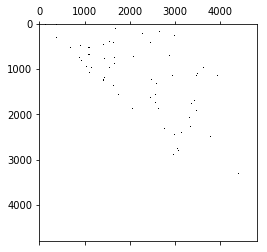

In [12]:
plt.spy(adjacency_weighted)

In [13]:
# We complete the low-half of the adjacency:

for i in range (len(credits_restricted)):
    for j in range (i+1,len(credits_restricted)):
        adjacency_weighted[j,i] = adjacency_weighted[i,j]

In [14]:
# We also build an unweighted adjacency:

for i in range (len(adjacency)):
    for j in range (len(adjacency)):
        if adjacency_weighted[i,j] != 0:
            adjacency[i,j] = 1

In [15]:
# We save the adjacency

np.savetxt('Dataset_Exports/First_Role/Adjacency_First_Role_Weighted.txt', adjacency_weighted)
np.savetxt('Dataset_Exports/First_Role/Adjacency_First_Role.txt', adjacency)

Let's normalize the weights.

In [16]:
adjacency_weighted_normalized = np.zeros((len(adjacency_weighted),len(adjacency_weighted)))

In [17]:
# We normalize the weights:

max_weight = np.max(adjacency_weighted)

for i in range (len(adjacency_weighted_normalized)):
    for j in range (len(adjacency_weighted_normalized)):
        if adjacency_weighted[i,j] == 0:
            adjacency_weighted_normalized[i,j] = 0
        else:
            adjacency_weighted_normalized[i,j] = adjacency_weighted[i,j]/max_weight

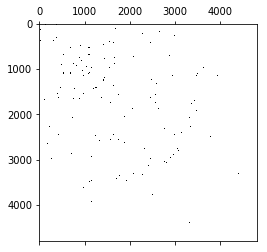

In [18]:
plt.spy(adjacency_weighted_normalized)

In [19]:
np.savetxt('Dataset_Exports/First_Role/Adjacency_First_Role_Weighted_Normalized.txt', adjacency_weighted_normalized)

## 2 - Exporting the graph for Gephi (by using Networkx)

Now we will create the graph of the adjacency we have built. We can quickly represent it here with Networkx but the core of our observations will be made with Gephi.

In [20]:
adjacency_weighted_normalized = np.loadtxt('Dataset_Exports/First_Role/Adjacency_First_Role_Weighted_Normalized.txt')

In [21]:
Graph = nx.from_numpy_array(adjacency_weighted_normalized)

D:\Programmes_DD\Applications\Anaconda3\envs\ntds_2018\lib\site-packages\networkx\drawing\nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


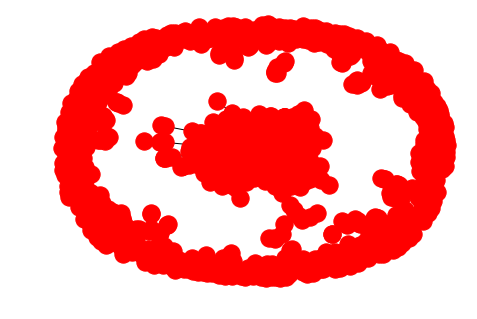

In [22]:
nx.draw_spring(Graph)

In [23]:
nx.write_gexf(Graph,'Dataset_Exports/First_Role/Graph_First_Role.gexf')